In [ ]:
import sys
sys.path.append('/Users/karl/mrl/')

In [ ]:
from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *

//anaconda3/envs/insight/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
from mrl.dataloaders import *
from mrl.chem import *
from mrl.core import *

C:\Users\GATEWAY\Anaconda2\envs\fastai_v2\lib\importlib\_bootstrap.py:219: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterCatalogEntry const > already registered; second conversion method ignored.
  return f(*args, **kwds)


In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

In [ ]:
model = LSTMLM(len(vocab.itos), 256, 1024, 3, vocab.stoi['pad'])

In [ ]:
model.load_state_dict(torch.load('untracked_files/smiles_lm.pt'))

<All keys matched successfully>

In [ ]:
model.cuda();

In [ ]:
from mrl.templates import *

In [ ]:
# template = Template([ValidityFilter(), SingleCompoundFilter()],
#                     [QEDFilter(None, None, score=PassThroughScore()),
#                      SAFilter(None, None, 
#                               score=PropertyFunctionScore(lambda x: (10-x)/9))], fail_score=-1.)

template = Template([ValidityFilter(), SingleCompoundFilter()],
                    [FPFilter.from_smiles(['CCN(CC)C(=O)C1CN(C2Cc3c[nH]c4c3c(ccc4)C2=C1)C',
                                           'CCN(CC)C(=O)C1CN(C2Cc3c[nH]c4c3c(ccc4)C2=C1)C'],
                        score=PropertyFunctionScore(lambda x: x.max()))], fail_score=-1.)



In [ ]:
preds, lps = model.sample_no_grad(100,100)
smiles = [vocab.reconstruct(i) for i in preds]

In [ ]:
os.environ['ncpus'] = '0'

In [ ]:
lps[0]

tensor([-1.2723e-01, -1.7745e+00, -8.4397e-01, -1.4067e-05, -4.9586e-02,
        -5.0757e-02, -3.1345e-01, -5.1511e-01, -2.1337e+00, -4.2084e-01,
        -2.9031e-02, -4.2183e-02, -4.1649e-02, -4.2915e-06, -9.7015e-01,
        -7.6850e-01, -2.3939e-02, -4.6610e-05, -5.0068e-06, -4.6310e-03,
        -1.2957e+00, -1.2310e-02, -1.6524e-01, -2.5445e+00, -4.6870e-01,
        -4.6492e-06, -1.5020e-05, -8.2051e-01, -1.9669e-05, -5.8349e-02,
        -2.2157e+00, -7.0333e-06, -5.9605e-07, -6.9516e-01, -3.3731e-04,
        -2.7418e-06, -5.3541e-01, -2.4554e-04, -1.6570e-05, -8.4332e-02,
        -7.7576e-01, -5.1260e-06, -3.1828e-05, -1.2875e-05, -1.0827e-02,
        -4.4455e-01, -3.4791e-04, -2.1357e+00, -1.2579e+00, -3.5405e-05,
        -1.5210e-04, -1.5497e-06, -3.9339e-06, -7.4573e-04, -1.8477e-05,
        -4.4107e-06, -1.0014e-05, -3.5763e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
data = TextDataset(smiles, vocab)

In [ ]:
x,y = data.collate_function([data[i] for i in range(len(data))])

In [ ]:
with torch.no_grad():
    out = model(x.cuda())

In [ ]:
out.shape

torch.Size([100, 71, 42])

In [ ]:
y.shape

torch.Size([100, 71])

In [ ]:
lps.shape

torch.Size([100, 100])

In [ ]:
out = F.log_softmax(out, -1)

In [ ]:
out.gather(2, y.cuda().unsqueeze(-1)).squeeze(-1)[0]

tensor([-1.2723e-01, -1.7745e+00, -8.4397e-01, -1.4067e-05, -4.9586e-02,
        -5.0757e-02, -3.1345e-01, -5.1511e-01, -2.1337e+00, -4.2084e-01,
        -2.9031e-02, -4.2183e-02, -4.1649e-02, -4.2915e-06, -9.7015e-01,
        -7.6850e-01, -2.3939e-02, -4.6610e-05, -5.0068e-06, -4.6310e-03,
        -1.2957e+00, -1.2310e-02, -1.6524e-01, -2.5445e+00, -4.6870e-01,
        -4.6492e-06, -1.5020e-05, -8.2051e-01, -1.9669e-05, -5.8349e-02,
        -2.2157e+00, -7.0333e-06, -5.9605e-07, -6.9516e-01, -3.3731e-04,
        -2.7418e-06, -5.3541e-01, -2.4554e-04, -1.6570e-05, -8.4332e-02,
        -7.7576e-01, -5.1260e-06, -3.1828e-05, -1.2875e-05, -1.0827e-02,
        -4.4455e-01, -3.4791e-04, -2.1357e+00, -1.2579e+00, -3.5405e-05,
        -1.5210e-04, -1.5497e-06, -3.9339e-06, -7.4573e-04, -1.8477e-05,
        -4.4107e-06, -1.0014e-05, -3.5763e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
lps[0]

tensor([-1.2723e-01, -1.7745e+00, -8.4397e-01, -1.4067e-05, -4.9586e-02,
        -5.0757e-02, -3.1345e-01, -5.1511e-01, -2.1337e+00, -4.2084e-01,
        -2.9031e-02, -4.2183e-02, -4.1649e-02, -4.2915e-06, -9.7015e-01,
        -7.6850e-01, -2.3939e-02, -4.6610e-05, -5.0068e-06, -4.6310e-03,
        -1.2957e+00, -1.2310e-02, -1.6524e-01, -2.5445e+00, -4.6870e-01,
        -4.6492e-06, -1.5020e-05, -8.2051e-01, -1.9669e-05, -5.8349e-02,
        -2.2157e+00, -7.0333e-06, -5.9605e-07, -6.9516e-01, -3.3731e-04,
        -2.7418e-06, -5.3541e-01, -2.4554e-04, -1.6570e-05, -8.4332e-02,
        -7.7576e-01, -5.1260e-06, -3.1828e-05, -1.2875e-05, -1.0827e-02,
        -4.4455e-01, -3.4791e-04, -2.1357e+00, -1.2579e+00, -3.5405e-05,
        -1.5210e-04, -1.5497e-06, -3.9339e-06, -7.4573e-04, -1.8477e-05,
        -4.4107e-06, -1.0014e-05, -3.5763e-07,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
all_scores = []

for i in range(100):
        
    preds, lps = model.sample_no_grad(512,90)
    smiles = [vocab.reconstruct(i) for i in preds]
    
    if np.random.rand(1)<0.05:
        print('seeding')
        smiles.append('CCN(CC)C(=O)C1CN(C2Cc3c[nH]c4c3c(ccc4)C2=C1)C')

    passes, fails = template.screen_mols(smiles)

    if passes:
        smiles = [i[0] for i in passes]
        scores = np.array([i[1] for i in passes])

        data = TextDataset(smiles, vocab)

        x,y = data.collate_function([data[i] for i in range(len(data))])

        lps = model(x.cuda())
        lps = F.log_softmax(lps, -1)
        lps = lps.gather(2, y.cuda().unsqueeze(-1)).squeeze(-1)

        all_scores.append(scores)
        scores = scores - scores.mean()

        opt.zero_grad()
        loss = -(lps.sum(-1))*torch.from_numpy(scores).cuda()
        loss = loss.mean()
        loss.backward()
        opt.step()

    if i%10==0:
        print(i, all_scores[-1].mean())

0 0.10146588268993592
10 0.1338634037010431
seeding
20 0.273065905888256
30 0.3125
40 0.3478260869565218
seeding
seeding
50 0.3492438563327031
seeding
seeding
60 0.3462030604883481
70 0.3478260869565217
seeding
80 0.3478260869565217
seeding
seeding
90 0.34734440309388576


In [ ]:
template.soft_log[template.soft_log.final>0.3]

,smiles,0,final
8527,CCN(CC)C(=O)C1C=C2c3cccc4[nH]cc(c34)CC2N(C)C1,1.000000,1.000000
8601,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN(C)C1,0.312500,0.312500
8667,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)N1C[C@H](C)C...,0.303030,0.303030
8668,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN(C)N1,0.309278,0.309278
8686,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN1C,0.347826,0.347826
8690,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN(C)S1(=O)=O,0.313131,0.313131
8693,CCN(C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN1N,0.302083,0.302083
8696,CCN(CC)C(=O)c1c[nH]c2cccc(C(=O)O)c12,0.310345,0.310345
8720,CCN(C(=O)C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN1C,0.340426,0.340426


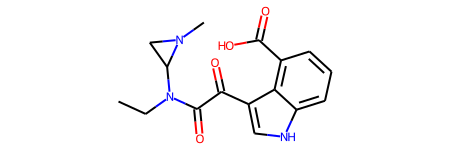

In [ ]:
to_mol('CCN(C(=O)C(=O)c1c[nH]c2cccc(C(=O)O)c12)C1CN1C')

torch/models roadmap

torch_core
    tensor operations
    gather
    
dataloaders
    vocab
    dataset
    dataloader

models
    LSTM LM
    VAE
    transformer
    contain supervised training loop
    dataset/dataloader

fastai

move onto torch/models
get protein model running
come back to chem/templates, remake with protein variants. code will hopefully be simpler


get collab working
get google search working

torch core
models (lstm, vae, transformer)
    work in protein stuff here

score functions

training loop

poicy gradients

q-network

diff-loss

exploration strategies

combichem

pharmacophore 


pages
overview

generrative screening primerr